In [1]:
%matplotlib inline

In [24]:
#librerias
import numpy as np
import time
from datetime import datetime
#from loaddata import *

#sklearn
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics as met
import joblib

import matplotlib
#new
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import pandas as pd
import seaborn as sns

#mne
import mne
from mne.decoding import CSP
from mne.channels import read_layout
from mne.channels import make_standard_montage
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne import Epochs, pick_types, events_from_annotations

from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs

#matplotlib.use('Qt5Agg')

In [25]:
runs = [3, 7, 11]  #Motor execution: left vs right hand

raw_fnames=[]
for subject in range(1, 2):
    raw_fnames.extend( eegbci.load_data(subject,runs= runs) )

#fnames = eegbci.load_data(subject=1, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
#raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

events.shape

Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']


(45, 3)

In [51]:
#Filtrar channles
raw.pick_channels(ch_names=['C3','Cz','C4','P3','Pz','P4','O1','O2'])

channel_names = ['C3','Cz','C4','P3','Pz','P4','O1','O2']
#Filtrar frequencia
#raw.filter(8., 12., fir_design='firwin', skip_by_annotation='edge')

In [79]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

tmin, tmax = 0.5, 2.5
event_ids = dict(left=2, right=3)  # map event IDs to tasks

#epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)

epochs = Epochs(raw, events, event_ids, tmin, tmax, proj=True,
                baseline=None, preload=True)
epochs

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped


Number of events,45
Events,left: 23right: 22
Time range,0.500 – 2.500 sec
Baseline,off


In [82]:
trials = {}
epochs0=epochs[epochs.events[:,2]==2]
epochs1=epochs[epochs.events[:,2]==3]

e0=epochs0.get_data(units='uV')
e1=epochs1.get_data(units='uV')
cl1='left'
cl2='right'

e0[0].shape

(8, 321)

In [ ]:
trials['left'] = e0.reshape(8, 321, 23)
trials['right'] = e1.reshape(8, 321, 22)

nchannels=8
nsamples=321
sample_rate=160


In [71]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        The frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 161, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [72]:
psd_l, freqs = psd(trials['left'])
psd_r, freqs = psd(trials['right'])
trials_PSD = {'left': psd_l, 'right': psd_r}


In [73]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

In [74]:
trials_PSD['left'][0]

array([[ 21.11473323,   9.62601998,   2.28593177, ...,  24.87398147,
         25.24466121,  25.47134777],
       [  5.96695134,   1.70668577,   0.40195444, ...,  34.02256919,
         26.32747083,  14.70911757],
       [ 48.13058081,  41.20092615,  32.46194816, ...,  77.88917837,
         63.03856788,  63.89158182],
       ...,
       [ 53.24538786,  71.44231466,  63.90961561, ...,  36.60536518,
         35.59134316,  42.61837844],
       [ 91.71924817, 149.90677908, 175.6484747 , ...,  31.06187951,
         61.96549094,  68.72619177],
       [ 41.32958811,  70.90536252, 107.08586092, ...,  11.98903298,
         57.76624002,  50.00613665]])

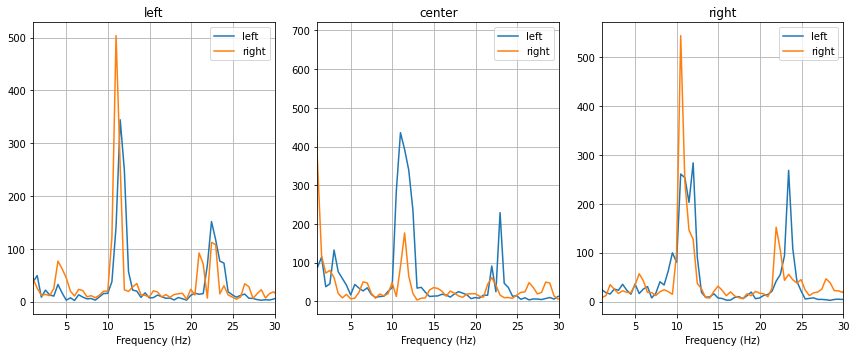

In [75]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right']
)

In [76]:
[channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']]

[0, 1, 2]

In [77]:
import scipy.signal 

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [78]:
# Apply the function
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}